In [1]:
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import folium
import re
print('Libraries imported.')

Libraries imported.


# 1. Data collecting

## 1.1. Basic and demographics data

First of all I collect basic and demographics information about zip code areas from www.zip-codes.com
I use regular expressions to parse webpages.

In [2]:
url = "https://www.zip-codes.com/state/fl.asp"
path = "https://www.zip-codes.com/state"
site = "https://www.zip-codes.com"

#From main page I collect following information: zipcode, city, county, type of zipcode,
#link to the page with detailed information
page1 = requests.get(url).text.replace('\n','').replace('\r','') #read the page to the variable
re1 = '<table[^>]*id="tblZIP"[^>]*>((?!</table>).)*</table>'
re2 = '(<tr(?:(?!</tr>).)*</tr>)'
re3 = '<tr><td><a href="([^"]*)"[^>]*>ZIP Code ([^<]*)</a></td><td><a[^>]*>([^<]*)</a></td><td><a[^>]*>([^<]*)</a></td><td>([^<]*)</td></tr>'
re4 = '</h2>(\s)*<table[^>]*>'
re4plus = '((?!</table>).)*</table>'
re5 = '<td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td>'
re6 = '<td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td>'
re7 = '<a[^<>]*href="([^"]*)"[^<>]*>[^<>]*More Census 2010 Data[^<>]*</a>'
re8 = '<td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td><td.*>([^<>]+)</.*td>'
table1 = re.search(re1,page1).group(0) #find needed table
rows1 = re.findall(re2,table1) #split the table into the rows
dtypes_dict = {'Zipcode':'int64',
               'City':'object',
               'County':'object',
               'Type':'object',
               'Latitude':'float64',
               'Longitude':'float64',
               'Link':'object'}
df_zipcodes = pd.DataFrame(columns=dtypes_dict.keys())
df_zipcodes = df_zipcodes.astype(dtypes_dict)


for i, row in enumerate(rows1[1:]):
    cells1 = re.findall(re3,row)[0] #split every row into the cells and write these values into DataFrame
    df_zipcodes.loc[i,'Zipcode'] = int(cells1[1])
    df_zipcodes.loc[i,'City'] = cells1[2]
    df_zipcodes.loc[i,'County'] = cells1[3]
    df_zipcodes.loc[i,'Type'] = cells1[4]
    df_zipcodes.loc[i,'Link'] = cells1[0]
    
    #Next using collected link I collect detailed information about zip code area
    link = cells1[0]
    zipcode = cells1[1]
    page2 = requests.get(path+link).text.replace('\n','').replace('\r','').replace('\t','')
    
    #Get latitude and longitude
    table2 = re.search(zipcode+' Data'+re4+re4plus*3,page2).group(0)
    rows2 = re.findall(re2,table2)
    df_temp = pd.DataFrame()
    for j, row2 in enumerate(rows2):
        cells2 = re.findall(re5,row2)[0]
        df_temp.loc[j,0] = cells2[0]
        df_temp.loc[j,1] = cells2[1]
    df_temp.set_index(0,inplace=True)
    df_zipcodes.loc[i,'Latitude'] = float(df_temp.loc['Latitude:',1])
    df_zipcodes.loc[i,'Longitude'] = float(df_temp.loc['Longitude:',1])
    
    #Get Current Population, 2010 Population, Number of Households and Average House Value
    table3 = re.search(zipcode+' 2010 Census Demographics'+re4+re4plus,page2).group(0)
    rows3 = re.findall(re2,table3)
    df_temp = pd.DataFrame()
    for j, row3 in enumerate(rows3):
        cells3 = re.findall(re5,row3)[0]
        df_temp.loc[j,0] = cells3[0]
        df_temp.loc[j,1] = cells3[1]
    df_temp.set_index(0,inplace=True)
    df_temp.loc[:,1] = df_temp.loc[:,1].apply(lambda x: x.replace(',','').replace('$',''))
    df_zipcodes.loc[i,'Current Population'] = int(df_temp.loc['Current Population:',1])
    df_zipcodes.loc[i,'2010 Population'] = int(df_temp.loc['2010 Population:',1])
    df_zipcodes.loc[i,'Number of Households'] = int(df_temp.loc['Households per ZIP Code:',1])
    df_zipcodes.loc[i,'Avarage House Value'] = int(df_temp.loc['Average House Value:',1])
    population = int(df_temp.loc['2010 Population:',1])
    #Also get white, black, hispanic and asian population share. This information is presented in absolute values
    #but because these groups overlap, so that their sum more than total population I decided to use shares
    if population > 0:
        df_zipcodes.loc[i,'White Population Share'] = int(df_temp.loc['White Population:',1]) / int(df_temp.loc['2010 Population:',1])
        df_zipcodes.loc[i,'Black Population Share'] = int(df_temp.loc['Black Population:',1]) / int(df_temp.loc['2010 Population:',1])
        df_zipcodes.loc[i,'Hispanic Population Share'] = int(df_temp.loc['Hispanic Population:',1]) / int(df_temp.loc['2010 Population:',1])
        df_zipcodes.loc[i,'Asian Population Share'] = int(df_temp.loc['Asian Population:',1]) / int(df_temp.loc['2010 Population:',1])
    
    #Get business and other information: Number of Businesses, Number of Mailboxes, Number of Employess, Land Area etc.
    table4 = re.search(zipcode+' Other Demographics'+re4+re4plus,page2).group(0)
    rows4 = re.findall(re2,table4)
    df_temp = pd.DataFrame()
    for j, row4 in enumerate(rows4[:-3]):
        try:
            cells4 = re.findall(re5,row4)[0]
            df_temp.loc[j,0] = cells4[0]
            df_temp.loc[j,1] = cells4[1]
        except:
            pass
    df_temp.set_index(0,inplace=True)  
    df_temp.loc[:,1] = df_temp.loc[:,1].apply(lambda x: x.replace(',','').replace('$','').replace(' sq mi',''))
    df_zipcodes.loc[i,'Residential Mailboxes'] = int(df_temp.loc['# Residential Mailboxes:',1])
    df_zipcodes.loc[i,'Business Mailboxes'] = int(df_temp.loc['# Business Mailboxes:',1])
    df_zipcodes.loc[i,'Total Delivery Receptacles'] = int(df_temp.loc['Total Delivery Receptacles:',1])
    df_zipcodes.loc[i,'Number of Businesses'] = int(df_temp.loc['Number of Businesses:',1])
    df_zipcodes.loc[i,'Annual Payroll'] = int(df_temp.loc['Annual Payroll:',1])
    df_zipcodes.loc[i,'Number of Employees'] = int(df_temp.loc['# of Employees:',1])
    df_zipcodes.loc[i,'Water Area'] = float(df_temp.loc['Water Area:',1])
    df_zipcodes.loc[i,'Land Area'] = float(df_temp.loc['Land Area:',1])
    
    #Get the number of Retired Workers and Disabled Workers
    table5 = re.search(zipcode+' Social Security Benefits'+re4+re4plus,page2).group(0)
    rows5 = re.findall(re2,table5)
    df_temp = pd.DataFrame()
    for j, row5 in enumerate(rows5):
        cells5 = re.findall(re6,row5)[0]
        df_temp.loc[j,0] = cells5[0]
        df_temp.loc[j,1] = cells5[1]
        df_temp.loc[j,2] = cells5[2]
        df_temp.loc[j,3] = cells5[3]
    df_temp.set_index(0,inplace=True)
    df_temp.loc[:,2] = df_temp.loc[:,2].apply(lambda x: x.replace(',',''))
    df_zipcodes.loc[i,'Number of Retired Workers'] = int(df_temp.loc['Retired Workers:',2])
    df_zipcodes.loc[i,'Number of Disabled Workers'] = int(df_temp.loc['Disabled Workers:',2])
    
    #Here I get detailed demographics information. I miss it if the type of zip code is P.O. Box that means that
    #there is no area related to this zipcode
    if df_zipcodes.loc[i,'Type'] != 'P.O. Box':
        try:
            link7 = re.findall(re7,page2)[0]
            page7 = requests.get(site+link7).text.replace('\n','').replace('\r','').replace('\t','')
            table7 = re.search('2010 Census data for ZIP Code '+zipcode+re4+re4plus,page7).group(0)
            rows7 = re.findall(re2,table7)
            df_temp = pd.DataFrame()
            for j, row7 in enumerate(rows7):
                cells7 = re.findall(re8,row7)
                if len(cells7) > 0:
                    df_temp.loc[j,0] = cells7[0][0]
                    df_temp.loc[j,1] = cells7[0][1]
            df_temp.loc[:,1] = df_temp.loc[:,1].apply(lambda x: x.replace(',',''))
            ii0 = df_temp.loc[df_temp[0]=='Male population of ZIP Code '+zipcode,:].index.values[0]
            ii1 = df_temp.loc[df_temp[0]=='Female population of ZIP Code '+zipcode,:].index.values[0]
            ii2 = df_temp.loc[df_temp[0]=='POPULATION BY RACE FOR ZIP Code '+zipcode,:].index.values[0]
            df_male = df_temp.loc[ii0:ii1,:]
            df_male.set_index(0, inplace=True)
            df_female = df_temp.loc[ii1:ii2,:]
            df_female.set_index(0, inplace=True)
            df_zipcodes.loc[i,'Male_0_4'] = int(df_male.loc['Under 5 years',1])
            df_zipcodes.loc[i,'Male_5_9'] = int(df_male.loc['5 to 9 years',1])
            df_zipcodes.loc[i,'Male_10_14'] = int(df_male.loc['10 to 14 years',1])
            df_zipcodes.loc[i,'Male_15_17'] = int(df_male.iloc[0,0]) - int(df_male.loc['18 years and over',1]) - int(df_male.loc['Under 5 years',1]) - int(df_male.loc['5 to 9 years',1]) - int(df_male.loc['10 to 14 years',1])
            df_zipcodes.loc[i,'Male_18_20'] = int(df_male.loc['18 years and over',1]) - int(df_male.loc['21 years and over',1])
            df_zipcodes.loc[i,'Male_21_24'] = int(df_male.loc['Under 5 years',1]) + int(df_male.loc['5 to 9 years',1]) + int(df_male.loc['10 to 14 years',1]) + int(df_male.loc['15 to 19 years',1]) + int(df_male.loc['20 to 24 years',1]) - int(df_male.iloc[0,0]) + int(df_male.loc['21 years and over',1])
            df_zipcodes.loc[i,'Male_25_29'] = int(df_male.loc['25 to 29 years',1])
            df_zipcodes.loc[i,'Male_30_34'] = int(df_male.loc['30 to 34 years',1])
            df_zipcodes.loc[i,'Male_35_39'] = int(df_male.loc['35 to 39 years',1])
            df_zipcodes.loc[i,'Male_40_44'] = int(df_male.loc['40 to 44 years',1])
            df_zipcodes.loc[i,'Male_45_49'] = int(df_male.loc['45 to 49 years',1])
            df_zipcodes.loc[i,'Male_50_54'] = int(df_male.loc['50 to 54 years',1])
            df_zipcodes.loc[i,'Male_55_59'] = int(df_male.loc['55 to 59 years',1])
            df_zipcodes.loc[i,'Male_60_64'] = int(df_male.loc['60 to 64 years',1])
            df_zipcodes.loc[i,'Male_65_69'] = int(df_male.loc['65 to 69 years',1])
            df_zipcodes.loc[i,'Male_70_74'] = int(df_male.loc['70 to 74 years',1])
            df_zipcodes.loc[i,'Male_75_79'] = int(df_male.loc['75 to 79 years',1])
            df_zipcodes.loc[i,'Male_80_84'] = int(df_male.loc['80 to 84 years',1])
            df_zipcodes.loc[i,'Male_85_inf'] = int(df_male.loc['85 years and over',1])
            df_zipcodes.loc[i,'Female_0_4'] = int(df_female.loc['Under 5 years',1])
            df_zipcodes.loc[i,'Female_5_9'] = int(df_female.loc['5 to 9 years',1])
            df_zipcodes.loc[i,'Female_10_14'] = int(df_female.loc['10 to 14 years',1])
            df_zipcodes.loc[i,'Female_15_17'] = int(df_female.iloc[0,0]) - int(df_female.loc['18 years and over',1]) - int(df_female.loc['Under 5 years',1]) - int(df_female.loc['5 to 9 years',1]) - int(df_female.loc['10 to 14 years',1])
            df_zipcodes.loc[i,'Female_18_20'] = int(df_female.loc['18 years and over',1]) - int(df_female.loc['21 years and over',1])
            df_zipcodes.loc[i,'Female_21_24'] = int(df_female.loc['Under 5 years',1]) + int(df_female.loc['5 to 9 years',1]) + int(df_female.loc['10 to 14 years',1]) + int(df_female.loc['15 to 19 years',1]) + int(df_female.loc['20 to 24 years',1]) - int(df_female.iloc[0,0]) + int(df_female.loc['21 years and over',1])
            df_zipcodes.loc[i,'Female_25_29'] = int(df_female.loc['25 to 29 years',1])
            df_zipcodes.loc[i,'Female_30_34'] = int(df_female.loc['30 to 34 years',1])
            df_zipcodes.loc[i,'Female_35_39'] = int(df_female.loc['35 to 39 years',1])
            df_zipcodes.loc[i,'Female_40_44'] = int(df_female.loc['40 to 44 years',1])
            df_zipcodes.loc[i,'Female_45_49'] = int(df_female.loc['45 to 49 years',1])
            df_zipcodes.loc[i,'Female_50_54'] = int(df_female.loc['50 to 54 years',1])
            df_zipcodes.loc[i,'Female_55_59'] = int(df_female.loc['55 to 59 years',1])
            df_zipcodes.loc[i,'Female_60_64'] = int(df_female.loc['60 to 64 years',1])
            df_zipcodes.loc[i,'Female_65_69'] = int(df_female.loc['65 to 69 years',1])
            df_zipcodes.loc[i,'Female_70_74'] = int(df_female.loc['70 to 74 years',1])
            df_zipcodes.loc[i,'Female_75_79'] = int(df_female.loc['75 to 79 years',1])
            df_zipcodes.loc[i,'Female_80_84'] = int(df_female.loc['80 to 84 years',1])
            df_zipcodes.loc[i,'Female_85_inf'] = int(df_female.loc['85 years and over',1])
            df_zipcodes.loc[i,'Owner Occupation Share'] = int(df_temp.loc[df_temp[0]=='Owner-occupied housing units',1]) / df_zipcodes.loc[i,'Number of Households']
        except:
            pass
        
#Finally I get the DataFrame with zipcodes and main demographics and business information about them
df_zipcodes.head(5)

KeyboardInterrupt: 

I added next 2 cells because parsing took a lot of time and I didn't want to repeat it every time I open this notebook. With these cells I could miss the parsing and get the data from previously saved csv-file.

In [ ]:
df_zipcodes['Zipcode'] = df_zipcodes['Zipcode'].astype('int64')
df_zipcodes.to_csv('df_zipcodes.csv')

In [2]:
df_zipcodes = pd.read_csv('df_zipcodes.csv',index_col=0)
df_zipcodes.head(5)

,Zipcode,City,County,Type,Latitude,Longitude,Link,Current Population,2010 Population,Number of Households,...,Female_45_49,Female_50_54,Female_55_59,Female_60_64,Female_65_69,Female_70_74,Female_75_79,Female_80_84,Female_85_inf,Owner Occupation Share
0,32003,Fleming Island,Clay,Standard,30.096584,-81.718908,/zip-code/32003/zip-code-32003.asp,30072.0,27126.0,9821.0,...,1414.0,1180.0,865.0,850.0,561.0,353.0,302.0,218.0,175.0,0.806435
1,32004,Ponte Vedra Beach,Saint Johns,P.O. Box,30.239600,-81.385500,/zip-code/32004/zip-code-32004.asp,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32006,Fleming Island,Clay,P.O. Box,30.107000,-81.717000,/zip-code/32006/zip-code-32006.asp,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32007,Bostwick,Putnam,P.O. Box,29.773900,-81.637300,/zip-code/32007/zip-code-32007.asp,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32008,Branford,Suwannee,Standard,29.910063,-82.873584,/zip-code/32008/zip-code-32008.asp,5302.0,5309.0,2177.0,...,209.0,189.0,226.0,198.0,186.0,142.0,99.0,54.0,58.0,0.815342


## 1.2. Taxes statistics

Now I read the information about the taxes. It is statistics of 2016, I downloaded this file at https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi

In [3]:
df_taxes = pd.read_csv('16zpallagi.csv')
df_taxes = df_taxes.loc[df_taxes['STATE']=='FL',:] #I save only zip codes of Florida
df_taxes = df_taxes[['zipcode','agi_stub','N1','A00100']].set_index(['zipcode','agi_stub']).unstack()
#The data in this csv-file is presented as a table with 2 levels index and a lot of columns,
#so I leave only needed columns, make DataFrame with 2 levels index and then unstack it.
#In the next line I change the names of the columns
df_taxes.columns = ['Num_0_25k','Num_25k_50k','Num_50k_75k','Num_75k_100k','Num_100k_200k','Num_200k_inf',
               'AGI_0_25k','AGI_25k_50k','AGI_50k_75k','AGI_75k_100k','AGI_100k_200k','AGI_200k_inf']
#Finally I get the one level index DataFrame where zipcode is index
df_taxes.drop([0,99999],inplace=True) #I delete rows with index 0 and 99999 that means total value and
                                      #other zipcodes respectively
df_taxes.head(10)

,Num_0_25k,Num_25k_50k,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,AGI_0_25k,AGI_25k_50k,AGI_50k_75k,AGI_75k_100k,AGI_100k_200k,AGI_200k_inf
zipcode,,,,,,,,,,,,
32003,3470,2200,1860,1520,2930,990,38806,81488,115510,132792,397756,362357
32008,870,580,300,160,140,20,11055,20483,18005,14022,18748,6660
32009,410,350,260,190,190,30,5255,12480,15948,16856,24147,6890
32011,2210,1710,1050,760,880,100,28866,62180,64817,65710,113363,35272
32024,3100,2040,1160,700,660,120,40583,73262,71273,60469,85185,43897
32025,3380,2280,950,500,460,80,45110,81944,58044,43039,58373,29252
32033,770,530,380,250,260,40,9759,19224,23627,21724,34067,13322
32034,4750,3030,2160,1720,3240,1530,59275,109504,134485,149746,446367,861872
32038,1670,1090,550,280,270,30,21546,38985,33677,24188,34496,10201


I combine demographics and taxes information into one DataFrame (df_overall)

In [4]:
df_overall = df_zipcodes.set_index('Zipcode')
df_overall = pd.concat([df_overall,df_taxes],axis=1)
df_overall.head()

,City,County,Type,Latitude,Longitude,Link,Current Population,2010 Population,Number of Households,Avarage House Value,...,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,AGI_0_25k,AGI_25k_50k,AGI_50k_75k,AGI_75k_100k,AGI_100k_200k,AGI_200k_inf
32003,Fleming Island,Clay,Standard,30.096584,-81.718908,/zip-code/32003/zip-code-32003.asp,30072.0,27126.0,9821.0,242700.0,...,1860.0,1520.0,2930.0,990.0,38806.0,81488.0,115510.0,132792.0,397756.0,362357.0
32004,Ponte Vedra Beach,Saint Johns,P.O. Box,30.239600,-81.385500,/zip-code/32004/zip-code-32004.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32006,Fleming Island,Clay,P.O. Box,30.107000,-81.717000,/zip-code/32006/zip-code-32006.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32007,Bostwick,Putnam,P.O. Box,29.773900,-81.637300,/zip-code/32007/zip-code-32007.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32008,Branford,Suwannee,Standard,29.910063,-82.873584,/zip-code/32008/zip-code-32008.asp,5302.0,5309.0,2177.0,74900.0,...,300.0,160.0,140.0,20.0,11055.0,20483.0,18005.0,14022.0,18748.0,6660.0


## 1.3. Venues information

In [5]:
# Credentials were removed before notebook import
CLIENT_ID = 'SJVA2OXRP31UOWWWUOZ0WTENDM0RRXBBN4FN21PCTN43XODA'
CLIENT_SECRET = 'ZSYIQDKOV4KPWYU15U5DXJVC1PL4QGBLX0PWZ4Y1R4MHRXNK'
VERSION = '20190715'
LIMIT = 100

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        try:
            res = categories_list[0]['name']
        except:
            try:
                res = json.loads(categories_list[1:-1].replace("'",'"').replace('True','true'))['name']
            except:
                res = None
        return res
def get_zipcode(str_zipcode, rtype='int'):
    """
    Get string variable with zipcode-like text and returns 5-digit zipcode in integer or string format
    """
    re11 = '^[0-9]{5}'
    match = re.search(re11, str_zipcode)
    if match:
        if rtype=='str':
            return str_zipcode[:5]
        else:
            return int(str_zipcode[:5])
    else:
        return None

In the next cell I collect information about the basic venues from Foursquare. I get name, category, latitude, longitude and zipcode.

In [7]:
radii = list([350,1180,4000,10400,27000]) #I want to get as more venues as possible that's why I apply 5 different radii

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']
#Additionally to name, category, latitude and longitude I need also postal code from Foursquare response.

#Create the DataFrame that will contains all found venues
#Because it worked not stable on labs.cognitiveclass.ai I had to realize intermediate saves
#So firstly code try to load already handled data and create new DataFrame only if it's not possible
try:
    all_venues = pd.read_csv('all_venues_rough.csv',index_col=0)
    izip = pd.read_csv('izip.csv',index_col=0).iloc[0,0]
except:
    all_venues = pd.DataFrame(columns=filtered_columns)
    izip = 0
istep = 50 #step for indermediate saves; so after handling of istep zipcodes venues are saved 
for iw in range ((df_zipcodes.shape[0]-izip) // istep + 1):
    istart = izip + iw * istep
    istop = min(df_zipcodes.shape[0],(izip + (iw+1) * istep))
                             
    for code, lat, lng in zip(df_zipcodes.loc[istart:istop,'Zipcode'],
                              df_zipcodes.loc[istart:istop,'Latitude'],
                              df_zipcodes.loc[istart:istop,'Longitude']):
        for radius in radii:
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
            for attempt in range(10):
                try:
                    results = requests.get(url).json()
                    venues = results['response']['groups'][0]['items']
                except:
                    pass
                else:
                    break
            norm_venues = json_normalize(venues) # flatten JSON
            if norm_venues.shape[0] > 0:
                all_venues = pd.concat([all_venues, norm_venues.loc[:, filtered_columns]],axis=0)
    all_venues.to_csv('all_venues_rough.csv') #intermediate save
    pd.DataFrame([[istop]]).to_csv('izip.csv')
    print('{} zipcodes are handled'.format(istop))

all_venues.drop_duplicates(inplace=True) #drop duplicates

# filter the category for each row
all_venues['venue.categories'] = all_venues.apply(get_category_type, axis=1)
all_venues.dropna(inplace=True, axis=0) #drop rows with missed values
all_venues.reset_index(drop=True, inplace=True)

# clean columns names
all_venues.columns = [col.split(".")[-1] for col in all_venues.columns]

# get zipcode as an integer from postalCode provided in Foursquare response
# it's important to understand that I use zipcodes latitude and longitude only to make the reuests
# while I get zipcode of venues from venue.location.postalCode value in the json Foursquare response
all_venues['zipcode'] = all_venues['postalCode'].apply(lambda x: get_zipcode(x))

#drop all rows that have postal code that it's not in predefined list of postal codes
#it can be wrong values or values outside Florida or something else
mask = all_venues['zipcode'].isin(df_zipcodes['Zipcode'])
all_venues.drop(all_venues.index.values[~mask], axis=0, inplace=True)
all_venues['zipcode'] = all_venues['zipcode'].astype('int64')
all_venues.drop('postalCode', axis=1, inplace=True)

all_venues.head(7)

1476 zipcodes are handled


,name,categories,lat,lng,zipcode
0,Michaels,Arts & Crafts Store,30.099020,-81.719354,32003
1,Kohl's,Department Store,30.099014,-81.720276,32003
2,Kirkland’s,Furniture / Home Store,30.099397,-81.718842,32003
3,Justice,Kids Store,30.099169,-81.718596,32003
4,MOJO Smokehouse BBQ & Blues,BBQ Joint,30.098140,-81.713397,32003
5,Mellow Mushroom,Pizza Place,30.098647,-81.713242,32003
6,Tijuana Flats,Tex-Mex Restaurant,30.101732,-81.718723,32003


In [8]:
all_venues.shape

(52556, 5)

Explore query returns most popular venues and it's enough to estimate the number of restaurants, bars etc. in the area but I need the more accurate number of gyms because it's our target variable, that's why I additionally run specialized queries that collect the information about Gym/Fitness in zipcode area. 

In [9]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']
gym_venues = pd.DataFrame(columns=filtered_columns)                       
for i, code in enumerate(df_zipcodes.loc[:,'Zipcode']):
    for q in ['Gym','Fitness']:
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&near={}&v={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, code, VERSION, LIMIT, q)
        #this time I used 'near' parameter instead of latitude/longitude
        for attempt in range(10):
            try:
                results = requests.get(url).json()
                venues = results['response']['groups'][0]['items']
            except:
                pass
            else:
                break
        norm_venues = json_normalize(venues) # flatten JSON
        if norm_venues.shape[0] > 0:
            gym_venues = pd.concat([gym_venues, norm_venues.loc[:, filtered_columns]],axis=0)
    if i%100 == 0:
        print('{} zipcodes are handled'.format(i))
gym_venues['venue.categories'] = gym_venues.apply(get_category_type, axis=1)
gym_venues.drop_duplicates(inplace=True) #drop duplicates
gym_venues.dropna(inplace=True, axis=0) #drop rows with missed values
gym_venues.reset_index(drop=True, inplace=True)
gym_venues.columns = [col.split(".")[-1] for col in gym_venues.columns]
gym_venues['zipcode'] = gym_venues['postalCode'].apply(lambda x: get_zipcode(x))
mask = gym_venues['zipcode'].isin(df_zipcodes['Zipcode'])
gym_venues.drop(gym_venues.index.values[~mask], axis=0, inplace=True)
gym_venues['zipcode'] = gym_venues['zipcode'].astype('int64')
gym_venues.drop('postalCode', axis=1, inplace=True)

0 zipcodes are handled


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


100 zipcodes are handled
200 zipcodes are handled
300 zipcodes are handled
400 zipcodes are handled
500 zipcodes are handled
600 zipcodes are handled
700 zipcodes are handled
800 zipcodes are handled
900 zipcodes are handled
1000 zipcodes are handled
1100 zipcodes are handled
1200 zipcodes are handled
1300 zipcodes are handled
1400 zipcodes are handled


In [10]:
gym_venues[['name','categories']].groupby('categories').count().sort_values('name',ascending=False).head(10)

,name
categories,
Gym / Fitness Center,2962
Gym,2676
Martial Arts Dojo,684
Yoga Studio,549
Weight Loss Center,249
College Gym,233
Gymnastics Gym,164
Pilates Studio,164
Hotel,140


I change the categories consisted the word 'Gym' to 'Gym and save only them. After that I add the information about the gyms to previously created DataFrame

In [11]:
gym_venues['categories'] = gym_venues['categories'].apply(lambda x: 'Gym' if 'Gym' in x else x)
gym_venues = gym_venues.loc[gym_venues['categories']=='Gym',:]
all_venues['categories'] = all_venues['categories'].apply(lambda x: 'Gym' if 'Gym' in x else x)
all_venues = pd.concat([all_venues,gym_venues],axis = 0)
all_venues['lat'] = all_venues['lat'].apply(lambda x: round(x,8))
all_venues['lng'] = all_venues['lng'].apply(lambda x: round(x,8))
all_venues.drop_duplicates(inplace=True)
all_venues.reset_index(drop=True,inplace=True)
all_venues.shape

(57231, 5)

In [12]:
all_venues.to_csv('all_venues.csv')

In [9]:
all_venues = pd.read_csv('all_venues.csv',index_col=0)
all_venues.shape

(57231, 5)

I change some categories in venues DataFrame. For example, change all restaurants (e.g. 'Mexican Restaurant', 'Italian Restaurant' etc.) to 'Restaurant' or change 'Pub' to 'Bar'. I make it in order to combine the similar categories and make new categories more valuable.

In [10]:
all_venues['categories'] = all_venues['categories'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
all_venues['categories'] = all_venues['categories'].apply(lambda x: 'Joint' if 'Joint' in x else x)
all_venues['categories'] = all_venues['categories'].apply(lambda x: 'Museum' if 'Museum' in x else x)

In [11]:
changes_dict = {'Frozen Yogurt Shop': 'Ice Cream Shop',
                'Spa': 'Health & Beauty Service',
                'Nail Salon': 'Health & Beauty Service',
                'Bagel Shop': 'Bakery',
                'Pie Shop': 'Bakery',
                'Beer Store': 'Liquor Store',
                'Wine Shop': 'Liquor Store',
                'Smoothie Shop': 'Juice Bar',
                'Wine Bar': 'Bar',
                'Pub': 'Bar',
                'Cocktail Bar': 'Bar',
                'Beer Bar': 'Bar',
                'Beer Garden': 'Bar',
                'Mobile Phone Shop': 'Electronics Store',
                'Camera Store': 'Electronics Store',
                'Hostel': 'Hotel',
                'Breakfast Spot': 'Café',
                'Golf Course': 'Athletics & Sports',
                'Baseball Field': 'Athletics & Sports',
                'Yoga Studio': 'Athletics & Sports',
                'Donut Shop': 'Dessert Shop',
                'Cupcake Shop': 'Dessert Shop',
                'Chocolate Shop': 'Dessert Shop',
                'Boutique': 'Clothing Store',
                'Shoe Store': 'Clothing Store',
                'Leather Goods Store': 'Clothing Store',
                'Soccer Field': 'Athletics & Sports',
                'Martial Arts Dojo': 'Athletics & Sports',
                'Cycle Studio': 'Athletics & Sports',
                'Basketball Court': 'Athletics & Sports',
                'Tennis Court': 'Athletics & Sports',
                'Pilates Studio': 'Athletics & Sports',
                'Paper / Office Supplies Store': 'Miscellaneous Shop',
                'Arts & Crafts Store': 'Miscellaneous Shop',
                'Hobby Shop': 'Miscellaneous Shop',
                'Salad Place': 'Café',
                'Hotel Pool': 'Pool',
                'Indie Movie Theater': 'Movie Theater',
                'Multiplex': 'Movie Theater',
                'Garden': 'Park',
                'Botanical Garden': 'Park',
                'Fruit & Vegetable Store': 'Grocery Store',
                'Organic Grocery': 'Grocery Store',
                'Strip Club': 'Nightclub'}
all_venues['categories'] = all_venues['categories'].apply(lambda x: changes_dict[x] if x in changes_dict else x)

I apply one hot encoding to the venues DataFrame and then group it by zip code.

In [12]:
# one hot encoding
florida_onehot = pd.get_dummies(all_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
florida_onehot['zipcode'] = all_venues['zipcode'] 

# move neighborhood column to the first column
fixed_columns = [florida_onehot.columns[-1]] + list(florida_onehot.columns[:-1])
florida_onehot = florida_onehot[fixed_columns]

florida_grouped = florida_onehot.groupby('zipcode').sum().reset_index()
florida_grouped.head()

,zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Warehouse Store,Watch Shop,Water Park,Waterfall,Waterfront,Weight Loss Center,Whisky Bar,Winery,Zoo,Zoo Exhibit
0,32003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Such a table consists 413 features, more of them are unuseful. I count total number of venue by category and measure correlation between each category and number of gyms and then save only the categories with correlation more than 0.04 and total number of venues more than 80. In fact I could apply more strict limits but I decided to save more features at this stage.

In [13]:
ser1 = all_venues['categories'].value_counts()
ser2 = florida_grouped.loc[florida_grouped['Gym']>0,'ATM':].corr(method='pearson').loc[:,'Gym'].sort_values(ascending=False)
df3 = pd.concat([ser2,ser1], axis=1, sort=False).sort_values('Gym',ascending=False)
df4 = df3.loc[np.logical_and(np.abs(df3['Gym'])>0.04,df3['categories']>80),:]
zipcode_venues = florida_grouped[['zipcode'] + list(df4.index.values[1:]) + ['Gym']].set_index('zipcode')
zipcode_venues.head()

,Restaurant,Coffee Shop,Bakery,Steakhouse,Ice Cream Shop,Health & Beauty Service,Juice Bar,Grocery Store,Cosmetics Shop,Dessert Shop,...,Scenic Lookout,Video Store,Dive Bar,Food,Home Service,Discount Store,Farm,Construction & Landscaping,Campground,Gym
zipcode,,,,,,,,,,,,,,,,,,,,,
32003,20,3,1,1,1,1,2,5,1,1,...,0,2,0,0,0,1,0,0,0,13
32007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32008,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
32009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32011,7,0,0,0,0,0,0,1,0,0,...,0,3,0,0,1,3,0,0,0,2


Finally I've got the DataFrame with 75 features + information about the number of gyms by zip code. And now I add these data to main DataFrame (df_overall)

In [14]:
df_overall = pd.concat([df_overall,zipcode_venues],axis=1)
df_overall.head()

,City,County,Type,Latitude,Longitude,Link,Current Population,2010 Population,Number of Households,Avarage House Value,...,Scenic Lookout,Video Store,Dive Bar,Food,Home Service,Discount Store,Farm,Construction & Landscaping,Campground,Gym
32003,Fleming Island,Clay,Standard,30.096584,-81.718908,/zip-code/32003/zip-code-32003.asp,30072.0,27126.0,9821.0,242700.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0
32004,Ponte Vedra Beach,Saint Johns,P.O. Box,30.239600,-81.385500,/zip-code/32004/zip-code-32004.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32006,Fleming Island,Clay,P.O. Box,30.107000,-81.717000,/zip-code/32006/zip-code-32006.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32007,Bostwick,Putnam,P.O. Box,29.773900,-81.637300,/zip-code/32007/zip-code-32007.asp,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32008,Branford,Suwannee,Standard,29.910063,-82.873584,/zip-code/32008/zip-code-32008.asp,5302.0,5309.0,2177.0,74900.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# 2. Data cleaning

I check the NaN values in df_overall

In [15]:
z = df_overall.shape[0]
a = df_overall.isna().any(axis=1).sum()
b = df_overall.loc[df_overall['Type']=='Standard'].isna().any(axis=1).sum()
c = df_overall.loc[df_overall['Type']=='P.O. Box'].isna().any(axis=1).sum()
d = df_overall.loc[df_overall['Type']=='Unique'].isna().any(axis=1).sum()
print('Totally there are {} rows'.format(z))
print('In {} rows there are NaN values'.format(a))
print('Among them:')
print('{} rows in rows with Standard Type'.format(b))
print('{} rows in rows with P.O. Box Type'.format(c))
print('{} rows in rows with Unique Type'.format(d))

Totally there are 1476 rows
In 559 rows there are NaN values
Among them:
17 rows in rows with Standard Type
491 rows in rows with P.O. Box Type
51 rows in rows with Unique Type


I see that most of them are in the rows with zipcode type 'P.O. Box' or 'Unique'. These types are not related to any area, it is used only in postal purposes, so it can be dropped with no doubts. But 17 rows are of Standard Type and I want to check all of them.

In [16]:
df_overall.loc[np.logical_and(df_overall['Type']=='Standard',df_overall.isna().any(axis=1))]

,City,County,Type,Latitude,Longitude,Link,Current Population,2010 Population,Number of Households,Avarage House Value,...,Scenic Lookout,Video Store,Dive Bar,Food,Home Service,Discount Store,Farm,Construction & Landscaping,Campground,Gym
32061,Lulu,Columbia,Standard,30.061772,-82.525084,/zip-code/32061/zip-code-32061.asp,353.0,283.0,107.0,189700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32062,Mc Alpin,Suwannee,Standard,30.131959,-82.981524,/zip-code/32062/zip-code-32062.asp,2552.0,2449.0,964.0,79300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32099,Jacksonville,Duval,Standard,30.338300,-81.770600,/zip-code/32099/zip-code-32099.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32143,Palm Coast,Flagler,Standard,29.584714,-81.207856,/zip-code/32143/zip-code-32143.asp,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32163,The Villages,Sumter,Standard,28.930000,-81.950000,/zip-code/32163/zip-code-32163.asp,38591.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
32334,Hosford,Liberty,Standard,30.263916,-84.766174,/zip-code/32334/zip-code-32334.asp,1507.0,1904.0,762.0,68400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32831,Orlando,Orange,Standard,28.474275,-81.141981,/zip-code/32831/zip-code-32831.asp,182.0,2542.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32834,Orlando,Orange,Standard,28.407800,-81.031400,/zip-code/32834/zip-code-32834.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33191,Miami,Miami Dade,Standard,25.787246,-80.323856,/zip-code/33191/zip-code-33191.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33192,Miami,Miami Dade,Standard,25.802401,-80.368254,/zip-code/33192/zip-code-33192.asp,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most of these rows looks strange: 0 population, 0 venues or huge difference between current population and population in 2010. Maybe 1 or 2 rows could be saved being handled in advance. But it's too small quantity, so finally I decide to drop all rows with missed values.

In [17]:
df_overall.dropna(inplace=True, axis=0)
df_overall.shape

(917, 151)

It's the end of the data preparation. Finally I've got DataFrame with 917 zip codes and 151 features

# 3. Exploratory analysis

Firstly I want to learn population density in Florida. I save the map instead of showing because anyway it will be missed after publishing on GitHub

In [18]:
df6 = df_overall.reset_index()[['index','2010 Population', 'Land Area']]
df6['Population Density'] = df6['2010 Population'] / df6['Land Area']
df6['zipcode'] = df6['index'].astype(str)
df6.drop('index', axis=1, inplace=True)
florida_geo = r'fl_florida_zip_codes_geo.min.json'

florida_map = folium.Map(location=[27.6648, -81.5158], zoom_start=7, tiles='cartodbpositron')

florida_map.choropleth(
    geo_data=florida_geo,
    data=df6,
    columns=['zipcode', 'Population Density'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlOrBr', 
    fill_opacity=0.85, 
    line_weight=0,
    legend_name='Florida population density',
    threshold_scale = [0,200,1000,3000,10000,40000],
    reset=True
)
florida_map.save('florida_density_map.html')

Now I learn the correlation between the features and number of gyms

In [19]:
df_corr = pd.DataFrame(df_overall.corr()['Gym'])
df_corr['Abs value'] = np.abs(df_corr['Gym'])
df_corr.sort_values('Abs value', inplace=True, ascending=False)
df_corr

,Gym,Abs value
Gym,1.000000,1.000000
Number of Businesses,0.788171,0.788171
Number of Employees,0.740391,0.740391
Restaurant,0.710476,0.710476
Annual Payroll,0.681689,0.681689
Business Mailboxes,0.656151,0.656151
Coffee Shop,0.632855,0.632855
Residential Mailboxes,0.589723,0.589723
Bakery,0.585308,0.585308
Total Delivery Receptacles,0.582558,0.582558


I compare the dependence of the number of gyms of number of businesses and population

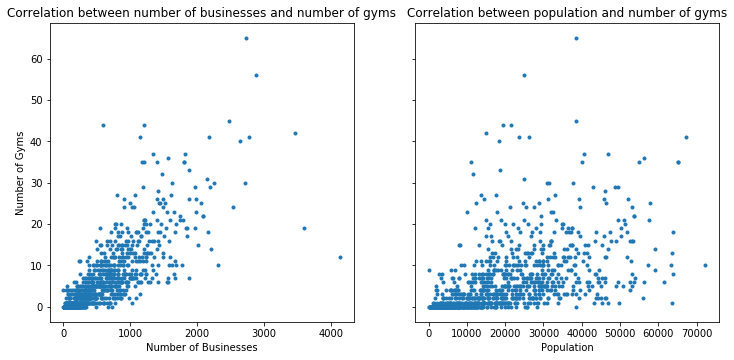

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5.5))
ax1.scatter(df_overall['Number of Businesses'], df_overall['Gym'], marker='.')
ax1.set_title('Correlation between number of businesses and number of gyms')
ax1.set_xlabel('Number of Businesses')
ax1.set_ylabel('Number of Gyms')
ax2.set_title('Correlation between population and number of gyms')
ax2.set_xlabel('Population')
ax2.scatter(df_overall['2010 Population'], df_overall['Gym'], marker='.')
fig.savefig('graph1.png')

I show the dependence of the number of gyms on some venue categories

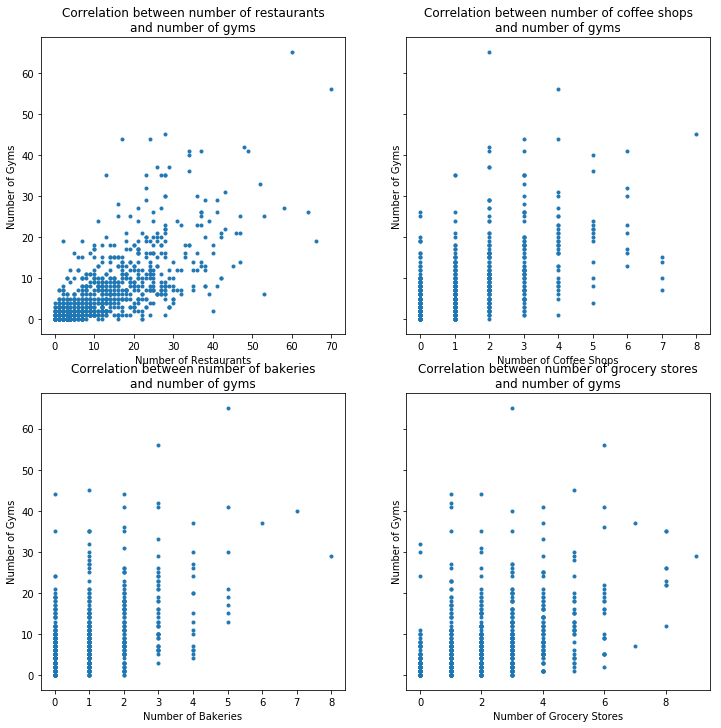

In [21]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12,12))
axes[0,0].scatter(df_overall['Restaurant'], df_overall['Gym'], marker='.')
axes[0,0].set_title('Correlation between number of restaurants\nand number of gyms')
axes[0,0].set_xlabel('Number of Restaurants')
axes[0,0].set_ylabel('Number of Gyms')
axes[0,1].scatter(df_overall['Coffee Shop'], df_overall['Gym'], marker='.')
axes[0,1].set_title('Correlation between number of coffee shops\nand number of gyms')
axes[0,1].set_xlabel('Number of Coffee Shops')
axes[0,1].set_ylabel('Number of Gyms')
axes[1,0].scatter(df_overall['Bakery'], df_overall['Gym'], marker='.')
axes[1,0].set_title('Correlation between number of bakeries\nand number of gyms')
axes[1,0].set_xlabel('Number of Bakeries')
axes[1,0].set_ylabel('Number of Gyms')
axes[1,1].scatter(df_overall['Grocery Store'], df_overall['Gym'], marker='.')
axes[1,1].set_title('Correlation between number of grocery stores\nand number of gyms')
axes[1,1].set_xlabel('Number of Grocery Stores')
axes[1,1].set_ylabel('Number of Gyms')
fig.savefig('graph2.png')

Now I show the dependence of the number of gyms on the most important demographic groups.

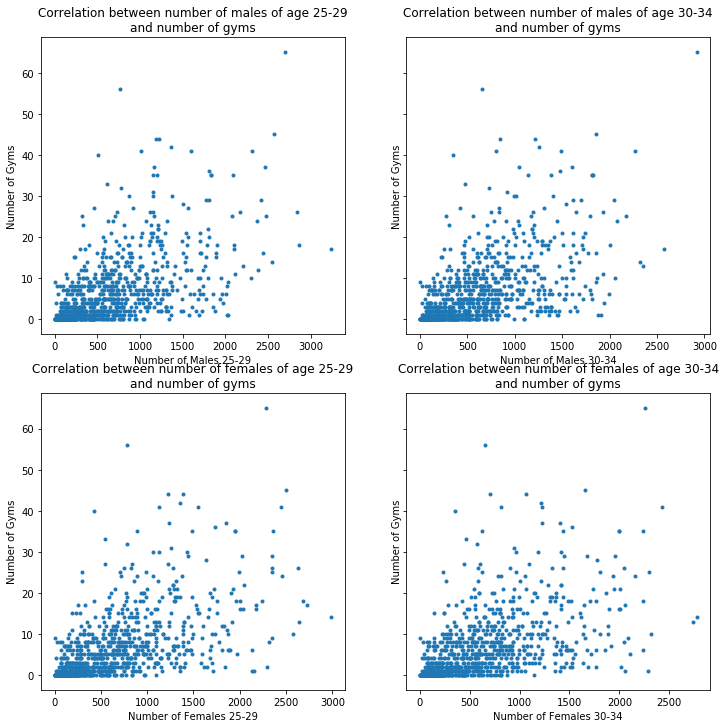

In [22]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12,12))
axes[0,0].scatter(df_overall['Male_25_29'], df_overall['Gym'], marker='.')
axes[0,0].set_title('Correlation between number of males of age 25-29\nand number of gyms')
axes[0,0].set_xlabel('Number of Males 25-29')
axes[0,0].set_ylabel('Number of Gyms')
axes[0,1].scatter(df_overall['Male_30_34'], df_overall['Gym'], marker='.')
axes[0,1].set_title('Correlation between number of males of age 30-34\nand number of gyms')
axes[0,1].set_xlabel('Number of Males 30-34')
axes[0,1].set_ylabel('Number of Gyms')
axes[1,0].scatter(df_overall['Female_25_29'], df_overall['Gym'], marker='.')
axes[1,0].set_title('Correlation between number of females of age 25-29\nand number of gyms')
axes[1,0].set_xlabel('Number of Females 25-29')
axes[1,0].set_ylabel('Number of Gyms')
axes[1,1].scatter(df_overall['Female_30_34'], df_overall['Gym'], marker='.')
axes[1,1].set_title('Correlation between number of females of age 30-34\nand number of gyms')
axes[1,1].set_xlabel('Number of Females 30-34')
axes[1,1].set_ylabel('Number of Gyms')
fig.savefig('graph3.png')

The dependence of the number of gyms on the 'Owner Occupation Share' feature

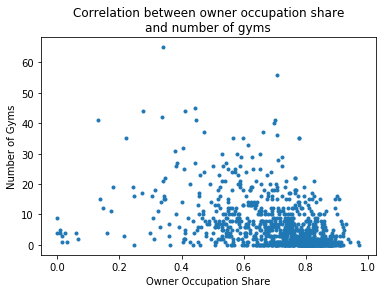

In [23]:
plt.scatter(df_overall['Owner Occupation Share'], df_overall['Gym'], marker='.')
plt.title('Correlation between owner occupation share\nand number of gyms')
plt.xlabel('Owner Occupation Share')
plt.ylabel('Number of Gyms')
plt.savefig('graph4.png')

And finally the dependence of the number of gyms on 'Asian Population Share' feature

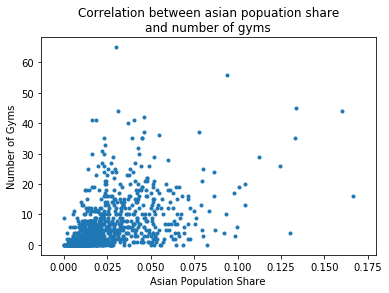

In [24]:
plt.scatter(df_overall['Asian Population Share'], df_overall['Gym'], marker='.')
plt.title('Correlation between asian popuation share\nand number of gyms')
plt.xlabel('Asian Population Share')
plt.ylabel('Number of Gyms')
plt.savefig('graph5.png')

# 4. Model

I will use gradient boosting regressor to predict the number of gyms. I will use KFold in order to predict the values for test set based on the data of train set. In order to smooth predictions I'd like to use more than one split. Now I want to understand good number of splits and check the model with different number of splits.

In [25]:
x = df_overall.drop(['City','County','Type','Latitude','Longitude','Link','Gym'],axis=1).values
y = df_overall['Gym'].values
y = y + (np.logical_not(y.astype(bool))) * np.exp(-1)
y = np.log(y)
n_randoms = range(1,11)
score = np.zeros(21)
for n_random in n_randoms:
    rss = range(17,17+n_random)
    y_hat_GBR = np.zeros(y.shape)
    f_imp = np.zeros(x.shape[1])
    for rs in rss:
        kf = KFold(n_splits=4,shuffle=True,random_state=rs)
        for train_index, test_index in kf.split(x):
            x_train = x[train_index]
            x_test = x[test_index]
            y_train = y[train_index]
            y_test = y[test_index]
            GBR = GradientBoostingRegressor(n_estimators=10000, n_iter_no_change=300, tol=0, random_state=rs,
                                            learning_rate=0.0085,
                                            subsample=0.22,
                                            max_features=0.63,
                                            max_depth=7)
            GBR.fit(x_train, y_train)
            y_hat_GBR[test_index] += GBR.predict(x_test) / n_random
            f_imp += GBR.feature_importances_ / (4* n_random)
    score[n_random] = mean_squared_error(y, y_hat_GBR)
    print('At {0} splits the mean squared error is {1}'.format(n_random, score[n_random]))

At 1 splits the mean squared error is 0.38271325121832017
At 2 splits the mean squared error is 0.38434509559080626
At 3 splits the mean squared error is 0.3777809937756555
At 4 splits the mean squared error is 0.3770352830791204
At 5 splits the mean squared error is 0.3743772206866606
At 6 splits the mean squared error is 0.37353244491236554
At 7 splits the mean squared error is 0.37594958046978244
At 8 splits the mean squared error is 0.3771292159334477
At 9 splits the mean squared error is 0.37573675191669137
At 10 splits the mean squared error is 0.3774816621826182


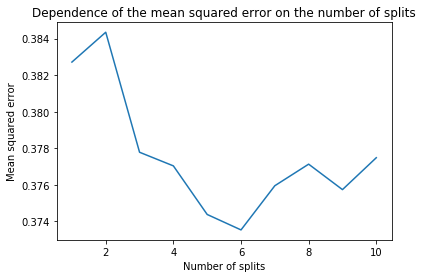

In [26]:
plt.plot(range(1,11),score[1:11])
plt.title('Dependence of the mean squared error on the number of splits')
plt.xlabel('Number of splits')
plt.ylabel('Mean squared error')
plt.savefig('graph6.png')

I decided to use 5 splits because further improvements are not significant while it make the model more complex.
So I use gradient boosting regressor as a predictive model. the parameters (learning_rate, subsample, max_features, max_depth) was tuned. As a target variable I use logarithm from the number of gyms. I use logarithm because I want to evaluate an error not as the difference between predicted and actual value but as quotient from division of predicted value by actual one; sklearn Gradient Boosting Regressor has a limited choice of error metrics, so the logarithm helps me to manage it. Unfortunately it makes one problem: log(0) = -inf; to solve it I change all zeros to exp(-1), so target variable for these cases will be -1.

In [27]:
x = df_overall.drop(['City','County','Type','Latitude','Longitude','Link','Gym'],axis=1).values
y = df_overall['Gym'].values
y = y + (np.logical_not(y.astype(bool))) * np.exp(-1)
y = np.log(y)
n_randoms = 5
rss = range(17,17+n_randoms)
score = 0
y_hat_GBR = np.zeros(y.shape)
f_imp = np.zeros(x.shape[1]) #array with features importances
for rs in rss:
    kf = KFold(n_splits=4,shuffle=True,random_state=rs)
    for train_index, test_index in kf.split(x):
        x_train = x[train_index]
        x_test = x[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        GBR = GradientBoostingRegressor(n_estimators=10000, n_iter_no_change=300, tol=0, random_state=rs,
                                        learning_rate=0.0085,#0.0085
                                        subsample=0.22,#0.22
                                        max_features=0.63,#0.63
                                        max_depth=7)
        GBR.fit(x_train, y_train)
        y_hat_GBR[test_index] += GBR.predict(x_test) / n_randoms
        f_imp += GBR.feature_importances_ / (4* n_randoms)
score += mean_squared_error(y, y_hat_GBR)
print(score)

0.3743772206866606


I've got the model with mean squared error 0.374 and want to build the scatter plots with actual and predicted values: first one shows the target variable (logarithm from the number of gyms) and predicted value of the model and the second plot shows predicted and actual number of gyms 

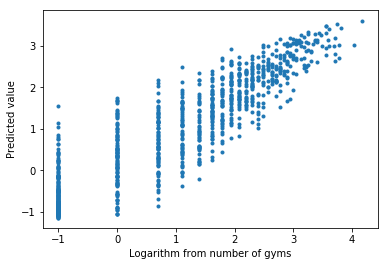

In [28]:
plt.scatter(y, y_hat_GBR, marker='.')
plt.xlabel('Logarithm from number of gyms')
plt.ylabel('Predicted value')
plt.savefig('graph7.png')

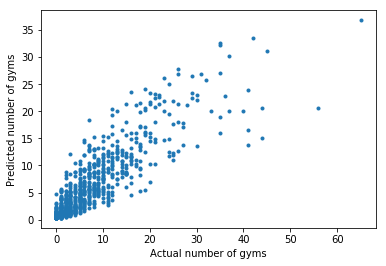

In [29]:
plt.scatter(np.around(np.exp(y)),np.exp(y_hat_GBR), marker='.')
plt.xlabel('Actual number of gyms')
plt.ylabel('Predicted number of gyms')
plt.savefig('graph8.png')

I estimate such a similiraty enough, especially taking into consideration that erroe includes not only the error of the model but also 'the error of real life' that I want to discover in this study. 

I counted the average feature importance over all 20 models and want to look at it now.

In [30]:
df4 = pd.DataFrame({'feature': df_overall.columns.values[6:-1], 'importance':f_imp})
df4.sort_values('importance',ascending=False).head(10).reset_index(drop=True)

,feature,importance
0,Number of Businesses,0.187601
1,Number of Employees,0.087879
2,Annual Payroll,0.060557
3,Business Mailboxes,0.054840
4,Restaurant,0.034511
5,Asian Population Share,0.034320
6,Owner Occupation Share,0.020166
7,Residential Mailboxes,0.020119
8,Land Area,0.017710
9,Num_200k_inf,0.016132


In the next cell I tried to apply Random Forest Regressor to the same data, I tuned this model but best result I've got was 0.411 that is worst than Gradient Boosting performed 

In [31]:
x = df_overall.drop(['City','County','Type','Latitude','Longitude','Link','Gym'],axis=1).values
y = df_overall['Gym'].values
y = y + (np.logical_not(y.astype(bool))) * np.exp(-1)
y = np.log(y)
n_randoms = 5
rss = range(17,17+n_randoms)
score = 0
y_hat_RFR = np.zeros(y.shape)
#f_imp = np.zeros(x.shape[1])
for rs in rss:
    kf = KFold(n_splits=4,shuffle=True,random_state=rs)
    for train_index, test_index in kf.split(x):
        x_train = x[train_index]
        x_test = x[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        RFR = RandomForestRegressor(n_estimators=250, random_state=rs, verbose=False,
                                    max_features=0.32, #0.32
                                    max_depth=13,#13
                                    max_leaf_nodes=332,#332
                                    bootstrap=False,
                                    n_jobs = 4)
        RFR.fit(x_train, y_train)
        y_hat_RFR[test_index] += RFR.predict(x_test) / n_randoms
        #f_imp += GBR.feature_importances_ / (4* n_randoms)
score += mean_squared_error(y, y_hat_RFR)
print(score)

0.41053508611871586


I also tried to use the blending of Gradient Boosting and Random Forest but is also didn't improve my model.

In [32]:
x = df_overall.drop(['City','County','Type','Latitude','Longitude','Link','Gym'],axis=1).values
y = df_overall['Gym'].values
y = y + (np.logical_not(y.astype(bool))) * np.exp(-1)
y = np.log(y)
n_randoms = 5
rss = range(17,17+n_randoms)
score = 0
y_hat_ENS = np.zeros(y.shape)
#f_imp = np.zeros(x.shape[1])
for rs in rss:
    kf = KFold(n_splits=4,shuffle=True,random_state=rs)
    for train_index, test_index in kf.split(x):
        x_train = x[train_index]
        x_test = x[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        RFR = RandomForestRegressor(n_estimators=250, random_state=rs, verbose=False,
                                    max_features=0.32, #0.32
                                    max_depth=13,#13
                                    max_leaf_nodes=332,#332
                                    bootstrap=False,
                                    n_jobs = 4)
        RFR.fit(x_train, y_train)
        GBR = GradientBoostingRegressor(n_estimators=10000, n_iter_no_change=300, tol=0, random_state=rs,
                                        learning_rate=0.0085,
                                        subsample=0.22,
                                        max_features=0.63,
                                        max_depth=7)
        GBR.fit(x_train, y_train)
        y_hat_ENS[test_index] += RFR.predict(x_test) / n_randoms / 2
        y_hat_ENS[test_index] += GBR.predict(x_test) / n_randoms / 2
        #f_imp += GBR.feature_importances_ / (4* n_randoms)
score += mean_squared_error(y, y_hat_ENS)
print(score)

0.38515944543377684


# 5. Ratio (index) calculation and results

So now having the predicted values of gyms I create the ratio as I defined as predicted value divided by actual one incremented by one. Increment is necessary because new opening will change the actual situation.
I print top 20 and bottom 20 according to the ratio

In [33]:
df7 = pd.DataFrame({'actual': np.around(np.exp(y)), 'predicted': np.exp(y_hat_GBR)}, index=df_overall.index)
df7['actual'] = df7['actual'].astype(int)
df7['actual+1'] = df7['actual'] + 1
df7['ratio'] = df7['predicted'] / df7['actual+1']
df7.sort_values('ratio',ascending=False,inplace=True)
df7.reset_index(inplace=True)
df7['zipcode'] = df7['index'].astype(str)
df7.drop('index', axis=1)
df7 = df7[['zipcode','actual','actual+1','predicted','ratio']]
df7.head(20)

,zipcode,actual,actual+1,predicted,ratio
0,32505,0,1,4.691647,4.691647
1,34983,0,1,3.130228,3.130228
2,33323,3,4,12.048341,3.012085
3,33331,2,3,8.837829,2.945943
4,33909,1,2,5.705526,2.852763
5,32579,0,1,2.797934,2.797934
6,33486,2,3,8.230125,2.743375
7,33023,1,2,5.459479,2.729739
8,33952,1,2,5.348582,2.674291
9,33460,1,2,5.334014,2.667007


In [34]:
df7.tail(20)

,zipcode,actual,actual+1,predicted,ratio
897,34759,5,6,1.380541,0.230090
898,32628,1,2,0.452278,0.226139
899,33570,6,7,1.566440,0.223777
900,34288,3,4,0.877348,0.219337
901,34758,5,6,1.267979,0.211330
902,34610,2,3,0.627834,0.209278
903,33972,1,2,0.412373,0.206186
904,32744,1,2,0.402322,0.201161
905,32066,1,2,0.402136,0.201068
906,32009,1,2,0.398737,0.199368


Next cells show the comparison of some interesting zipcodes. I use this comparison in my report.

In [35]:
df_overall.loc[[32505,32503],['City','Current Population','Number of Households','Avarage House Value',
                              'White Population Share','Black Population Share','Number of Businesses',
                              'Male_25_29','Female_25_29', 'Num_0_25k', 'Num_25k_50k', 'Num_50k_75k',
                              'Num_75k_100k', 'Num_100k_200k', 'Num_200k_inf', 'Restaurant', 'Grocery Store',
                              'Café', 'Gym']]

,City,Current Population,Number of Households,Avarage House Value,White Population Share,Black Population Share,Number of Businesses,Male_25_29,Female_25_29,Num_0_25k,Num_25k_50k,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,Restaurant,Grocery Store,Café,Gym
32505,Pensacola,30559.0,10756.0,64200.0,0.404034,0.553291,724.0,957.0,969.0,7090.0,2790.0,840.0,380.0,360.0,80.0,8.0,2.0,4.0,0.0
32503,Pensacola,31850.0,12724.0,147500.0,0.672269,0.290275,851.0,1030.0,1143.0,6170.0,3660.0,1850.0,1040.0,1460.0,610.0,14.0,2.0,2.0,4.0


In [36]:
df7.loc[np.logical_or(df7['zipcode']=='32505',df7['zipcode']=='32503'),:]

,zipcode,actual,actual+1,predicted,ratio
0,32505,0,1,4.691647,4.691647
34,32503,4,5,8.861295,1.772259


In [37]:
df_overall.loc[[33323,33314],
               ['City','Current Population','Avarage House Value',
                'White Population Share','Black Population Share',
                'Hispanic Population Share','Number of Businesses','Number of Employees',
                'Male_25_29','Female_25_29', 'Num_0_25k', 'Num_25k_50k', 'Num_50k_75k',
                'Num_75k_100k', 'Num_100k_200k', 'Num_200k_inf', 'Restaurant', 'Grocery Store',
                'Café', 'Gym']]

,City,Current Population,Avarage House Value,White Population Share,Black Population Share,Hispanic Population Share,Number of Businesses,Number of Employees,Male_25_29,Female_25_29,Num_0_25k,Num_25k_50k,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,Restaurant,Grocery Store,Café,Gym
33323,Fort Lauderdale,24455.0,283800.0,0.743991,0.172223,0.276454,1141.0,31564.0,584.0,673.0,3320.0,2350.0,1650.0,1200.0,1760.0,470.0,23.0,3.0,2.0,3.0
33314,Fort Lauderdale,26824.0,154700.0,0.755723,0.137629,0.335572,1073.0,16934.0,1025.0,1073.0,5390.0,3290.0,1490.0,730.0,700.0,190.0,16.0,3.0,1.0,13.0


In [38]:
all_venues.loc[np.logical_and(all_venues['categories']=='Gym', all_venues['zipcode']==34758),:]

,name,categories,lat,lng,zipcode
41914,Anytime Fitness,Gym,28.254290,-81.481690,34758
54885,Hardcore nutrition and catering,Gym,25.822318,-80.187428,34758
56652,crossfit hyperdrive,Gym,28.247008,-81.494590,34758
56655,Apex Training Gym,Gym,28.148000,-81.453200,34758
57170,JBoFitness,Gym,28.279975,-81.416726,34758


In [39]:
df_overall.loc[[34758,34743],['City','Current Population','Number of Households','Avarage House Value',
                              'White Population Share','Black Population Share','Number of Businesses',
                              'Male_25_29','Female_25_29', 'Num_0_25k', 'Num_25k_50k', 'Num_50k_75k',
                              'Num_75k_100k', 'Num_100k_200k', 'Num_200k_inf', 'Restaurant', 'Grocery Store',
                              'Café', 'Gym']]

,City,Current Population,Number of Households,Avarage House Value,White Population Share,Black Population Share,Number of Businesses,Male_25_29,Female_25_29,Num_0_25k,Num_25k_50k,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,Restaurant,Grocery Store,Café,Gym
34758,Kissimmee,43371.0,9168.0,156000.0,0.588102,0.272677,203.0,848.0,862.0,9360.0,5220.0,1920.0,750.0,460.0,30.0,1.0,0.0,0.0,5.0
34743,Kissimmee,40136.0,10555.0,150100.0,0.660026,0.157945,296.0,1107.0,1119.0,9710.0,5700.0,1880.0,730.0,420.0,0.0,0.0,0.0,0.0,3.0


In [40]:
df7.loc[np.logical_and(df7['actual']<10,df7['predicted']>16),:]

,zipcode,actual,actual+1,predicted,ratio
13,32073,7,8,18.354365,2.294296


In [ ]:
df_overall.loc[[32073,32223],['City','Current Population','Number of Households','Avarage House Value',
                              'White Population Share','Black Population Share','Number of Businesses',
                              'Male_25_29','Female_25_29', 'Num_0_25k', 'Num_25k_50k', 'Num_50k_75k',
                              'Num_75k_100k', 'Num_100k_200k', 'Num_200k_inf', 'Restaurant', 'Grocery Store',
                              'Café', 'Gym']]

,City,Current Population,Number of Households,Avarage House Value,White Population Share,Black Population Share,Number of Businesses,Male_25_29,Female_25_29,Num_0_25k,Num_25k_50k,Num_50k_75k,Num_75k_100k,Num_100k_200k,Num_200k_inf,Restaurant,Grocery Store,Café,Gym
32073,Orange Park,43934.0,14871.0,157600.0,0.757066,0.179676,1333.0,1306.0,1287.0,7300.0,5590.0,2970.0,1890.0,2030.0,370.0,35.0,4.0,4.0,7.0
32223,Jacksonville,26857.0,9556.0,243100.0,0.910842,0.057048,813.0,569.0,548.0,3540.0,2620.0,1820.0,1370.0,2380.0,770.0,19.0,6.0,2.0,9.0


In [ ]:
df7.loc[df7['predicted']>30,:].head(3)

,zipcode,actual,actual+1,predicted,ratio
251,33411,35,36,32.549966,0.904166
260,33411,35,36,32.151062,0.893085
335,32746,37,38,30.143520,0.793251


And finally I create the map where zip code areas are colored according to the ratio, save this map and also save full list of zip codes with actual and predicted number of gyms as well as with ratio.

In [ ]:
florida_geo = r'fl_florida_zip_codes_geo.min.json'

florida_map = folium.Map(location=[27.6648, -81.5158], zoom_start=7, tiles='cartodbpositron')

florida_map.choropleth(
    geo_data=florida_geo,
    data=df7,
    columns=['zipcode', 'ratio'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Gym opening opportunities index',
    threshold_scale = [0,0.4,0.8,1.2,2.4,4.8],
    reset=True
)

florida_map.save('florida_map.html')

In [ ]:
df7.sort_values('zipcode').to_excel('index.xlsx',index=False)